### Try to load the pre-trained model

In [1]:
import os
import re
import pickle
import numpy as np
SETS = ['training', 'validation', 'tests']
GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
models_path = 'models'
dataset_genres_path = 'genres'

In [2]:

try:
    with open(os.path.join(models_path,'dtcwt.bin'),'rb') as mod:
        dtcwt_RF = pickle.load(mod)
        loaded_model = True
except:
    loaded_model = False
loaded_model

True

### Load the dataset

In [23]:
def load_dataset():       
    X_paths = []
    y  = []      
    for genre in GENRES:
        for wav in os.listdir(os.path.join(dataset_genres_path,genre)):            
            if wav == 'jazz.00054.wav': continue
            matched = re.match(r"(\w+).(\d+).wav", wav)
            if matched:
                path = os.path.join(dataset_genres_path,os.path.join(genre,wav))
                y.append(genre)
                X_paths.append(path)
    return X_paths, y
#     X_paths = np.array(X_paths)
#     y = np.array(y)
#     np.save('dtcwt/dtcwt_15_lvl17', x_features)
#     np.save('dtcwt/dtcwt_y', y)
#     return x_features, y

# try:
#     X_dtcwt = np.load('dtcwt/dtcwt_15_lvl17.npy')
#     y = np.load('dtcwt/dtcwt_y.npy')
# except:
#     X_dtcwt, y = load_dataset()
#     X_dtcwt = np.load('dtcwt/dtcwt_15_lvl17.npy')
#     y = np.load('dtcwt/dtcwt_y.npy')
# X_dtcwt.shape

In [31]:
if not loaded_model:
    X_paths, y = load_dataset()
    X_paths, y

(['genres\\blues\\blues.00000.wav',
  'genres\\blues\\blues.00001.wav',
  'genres\\blues\\blues.00002.wav',
  'genres\\blues\\blues.00003.wav',
  'genres\\blues\\blues.00004.wav',
  'genres\\blues\\blues.00005.wav',
  'genres\\blues\\blues.00006.wav',
  'genres\\blues\\blues.00007.wav',
  'genres\\blues\\blues.00008.wav',
  'genres\\blues\\blues.00009.wav',
  'genres\\blues\\blues.00010.wav',
  'genres\\blues\\blues.00011.wav',
  'genres\\blues\\blues.00012.wav',
  'genres\\blues\\blues.00013.wav',
  'genres\\blues\\blues.00014.wav',
  'genres\\blues\\blues.00015.wav',
  'genres\\blues\\blues.00016.wav',
  'genres\\blues\\blues.00017.wav',
  'genres\\blues\\blues.00018.wav',
  'genres\\blues\\blues.00019.wav',
  'genres\\blues\\blues.00020.wav',
  'genres\\blues\\blues.00021.wav',
  'genres\\blues\\blues.00022.wav',
  'genres\\blues\\blues.00023.wav',
  'genres\\blues\\blues.00024.wav',
  'genres\\blues\\blues.00025.wav',
  'genres\\blues\\blues.00026.wav',
  'genres\\blues\\blues.0002

### Extract DT-CWT features

In [32]:
import wavelets_extraction

X_features = []
for wav in X_paths:
    features = wavelets_extraction.extract_dtcwt(wav)
    X_features.append(features)

X = np.array(X_features)
y = np.array(y)


Save the features if desired

In [33]:
np.save('dtcwt_15_lvl17', X)
np.save('dtcwt_y', y)

In [3]:
X = np.load('dtcwt_15_lvl17.npy')
y = np.load('dtcwt_y.npy')

### Use the generic split.
Score the model on that split with validation set, test set and both together. That way the results can be compared with other models or other features, don't matter on wich set they evaluate themself.

In [7]:
import random_split
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y = encoder.fit_transform(y)

X_train, y_train, X_validation, y_validation, X_test, y_test = random_split.generic_random_split(X, y)
X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape

((799, 216), (799,), (100, 216), (100,), (100, 216), (100,))

In [8]:
X_val_test = np.concatenate((X_validation, X_test))
y_val_test = np.concatenate((y_validation, y_test))

In [52]:
from sklearn.ensemble import RandomForestClassifier

if not loaded_model:
    # retrain model
    dtcwt_RF = RandomForestClassifier(n_estimators=100, max_depth=13, bootstrap=False, random_state=13)
    dtcwt_RF.fit(X_train,y_train)

    with open(os.path.join(models_path,'dtcwt.bin'),'wb') as mod:
        pickle.dump(dtcwt_RF, mod)

In [9]:
# X_validation
print("Acurracy score on validation set: ", dtcwt_RF.score(X_validation, y_validation))
ypred_validation = dtcwt_RF.predict(X_validation)
# X_test
print("Acurracy score on test set: ", dtcwt_RF.score(X_test, y_test))
ypred_test = dtcwt_RF.predict(X_test)
# X_validation join X_test
print("Acurracy score on (validation + test) set: ", dtcwt_RF.score(X_val_test, y_val_test))
ypred_val_test = dtcwt_RF.predict(X_val_test)

Acurracy score on validation set:  0.78
Acurracy score on test set:  0.78
Acurracy score on (validation + test) set:  0.78


Plot a confusion matrix to corroborate the behavior of the model for each genre

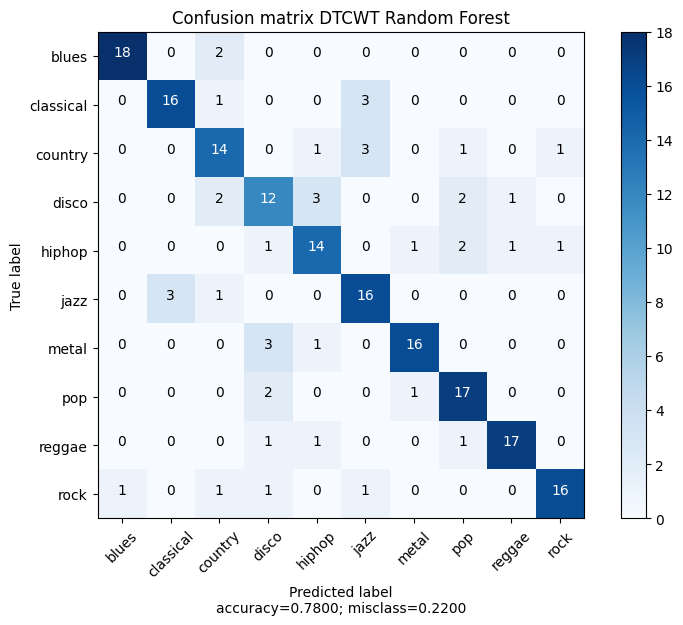

In [12]:
import reports_functions
reports_functions.plot_confusion_matrix(y_val_test,ypred_val_test, 'ConfM_dtcwt_RF.png','Confusion matrix DTCWT Random Forest')

A Cross-Validation using K-Fold to validate the accuracy of the previous fit

scores:  [0.73529412 0.73529412 0.67647059 0.82352941 0.73529412 0.79411765
 0.82352941 0.76470588 0.91176471 0.90909091 0.75757576 0.84848485
 0.66666667 0.90909091 0.81818182 0.84848485 0.84848485 0.78787879
 0.72727273 0.66666667 0.96969697 0.78787879 0.78787879 0.72727273
 0.75757576 0.63636364 0.75757576 0.63636364 0.81818182 0.72727273]
mean:  0.7797979797979798
std:  0.08197251366859774


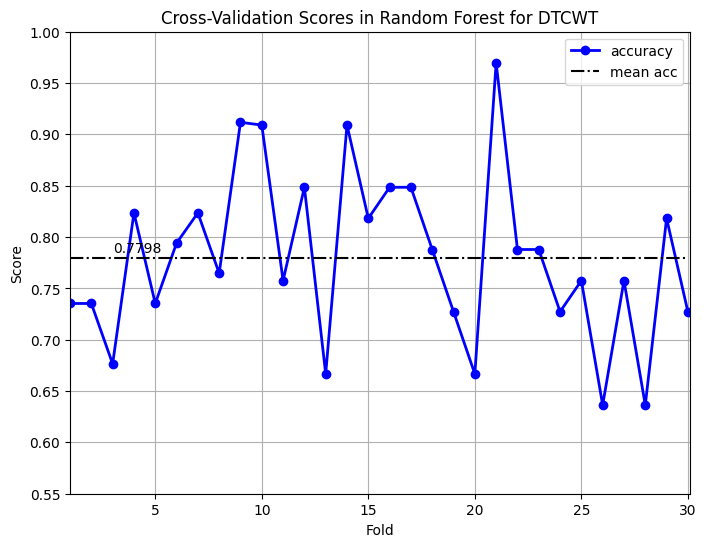

In [4]:
import reports_functions
reports_functions.cross_validation_accuracy(dtcwt_RF,X,y,30,'CV_dtcwt_RF.png','Cross-Validation Scores in Random Forest for DTCWT',(0.55,1))